In [1]:
import torch
from torch import nn, optim
from transformers import MarianMTModel, MarianTokenizer

import math
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


#### 모델구현

* Embedding
* PositionalEncoding 

* Encoder  
    * EncoderLayer  
        *  MultiHeadAttention
        *  FeedForward
    
* Decoder
    * DecoderLayer
        * MultiHeadAttention
        *  FeedForward 
    
     
* Transformer
    * Encoder
    * Decoder   

<p style="text-align: center;">
<img src="https://github.com/LeeHyeJin91/PapersWithCode/assets/43728746/3624554e-dc88-401c-be49-239eb4577b43" width="300" height="300"/>
</p>

In [3]:
class Embedding(nn.Embedding):

    def __init__(self, vocab_size, d_model):
        super().__init__(vocab_size, d_model)
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False) 
    
    def forward(self, x):
        # input
        #       x(batch_size, seq_len)
        # output
        #       x_embd(batch_size, seq_len, d_model)

        x_embd = self.embedding(x)
        
        return x_embd
        

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()

        self.encoding = torch.zeros(max_len, d_model)
        self.encoding.requires_grad = False 

        pos = torch.arange(0, max_len)     # (max_len)
        pos = pos.float().unsqueeze(dim=1) # (max_len, 1)

        _2i = torch.arange(0, d_model, step=2).float() # [0, 2, 4, ...]
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        # input
        #      x(batch_size, seq_len)
        # output
        #      x_pe(batch_size, seq_len, d_model)

        batch_size, seq_len = x.size()
        x_pe = self.encoding[:seq_len, :]

        return x_pe 
        

In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super().__init__()

        self.d_model = d_model
        self.n_head = n_head
        self.scale = torch.sqrt(torch.tensor(int(d_model//n_head)))

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # input:
        #        q (batch_size, seq_len, d_model)
        #        k (batch_size, seq_len, d_model)
        #        v (batch_size, seq_len, d_model) 
        # output: 
        #        x                (batch_size, seq_len, d_model)
        #        attention_weight (batch_size, n_head, seq_len, seq_len)
        
        Q = self.WQ(q) # (batch_size, seq_len, d_model)
        K = self.WK(k) # (batch_size, seq_len, d_model)
        V = self.WV(v) # (batch_size, seq_len, d_model)

        batch_size, seq_len, d_model = Q.size()
        d = self.d_model // self.n_head
        
        Q = Q.reshape(batch_size, -1, n_head, d).permute(0,2,1,3) # (batch_size, n_head, seq_len, d_model//n_head)
        K = K.reshape(batch_size, -1, n_head, d).permute(0,2,1,3) # (batch_size, n_head, seq_len, d_model//n_head) 
        V = V.reshape(batch_size, -1, n_head, d).permute(0,2,1,3) # (batch_size, n_head, seq_len, d_model//n_head) 
        
        # attention 연산
        
        # 1) 유사도 계산
        attention_score = (Q @ K.permute(0, 1, 3, 2)) / self.scale # (batch_size, n_head, seq_len, seq_len)  
        
        # 2) 가중치 계산
        if mask is not None:
            attention_score[mask] = -1e10
        attention_weight = torch.softmax(attention_score, dim=-1) # (batch_size, n_head, seq_len, seq_len)  

        # 3) 가중합 계산 
        x = attention_weight @ V                                 # (batch_size, n_head, seq_len, d_model//n_head)
        x = x.permute(0,2,1,3).reshape(batch_size, -1, d_model)  # (batch_size, seq_len, d_model)

        return x, attention_weight
    

In [6]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, drop_prob=0.1):
        super().__init__()

        self.linear1 = nn.Linear(d_model, d_ff, bias=True) # (d_model, d_ff)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_prob)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # input
        #       x(batch_size, seq_len, d_model)
        # output
        #       x(batch_size, seq_len, d_model)

        x = self.linear1(x)  # (batch_size, seq_len, d_ff)
        x = self.relu(x)     # (batch_size, seq_len, d_ff)
        x = self.dropout(x)  # (batch_size, seq_len, d_ff)
        x = self.linear2(x)  # (batch_size, seq_len, d_model)

        return x
        

In [7]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_ff, n_head, drop_prob):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, n_head)
        self.ln1 = nn.LayerNorm(d_model)

        self.feedforward = FeedForward(d_model, d_ff, drop_prob)
        self.ln2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_prob)

    def forward(self, enc_x, enc_mask):
        # input 
        #       enc_x    (batch_size, enc_seq_len, d_model)
        #       enc_mask ()
        # output
        #       x                (batch_size, enc_seq_len, d_model)
        #       attention_weight (batch_size, n_head, enc_seq_len, enc_seq_len)

        residual, attention_weight = self.self_attention(q=enc_x, k=enc_x, v=enc_x, mask=enc_mask) 
        residual = self.dropout(residual)
        x = self.ln1(enc_x + residual)

        residual = self.feedforward(x)
        residual = self.dropout(residual)
        x = self.ln2(x + residual)

        return x, attention_weight
        
class Encoder(nn.Module):

    def __init__(self, vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers):
        super().__init__()

        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(drop_prob)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_head, drop_prob) for _ in range(n_layers)])
        
    def forward(self, enc_x, enc_mask):
        # input
        #      enc_x(batch_size, seq_len)
        #      enc_mask()
        # output
        #      x                 (batch_size, seq_len, d_model)
        #      attention_weights (batch_size, n_head, seq_len, seq_len)
        
        x_embd = self.embedding(enc_x).to(device)    # (batch_size, seq_len, d_model)
        x_pos = self.pos_encoding(enc_x).to(device)  # (batch_size, seq_len, d_model)
        x = x_embd + x_pos                           # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        for layer in self.layers: 
            x, attention_weight = layer(x, enc_mask) 
       
        return x, attention_weight
        

In [8]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_ff, n_head, drop_prob):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(d_model, n_head)
        self.ln1 = nn.LayerNorm(d_model)

        self.enc_dec_attention = MultiHeadAttention(d_model, n_head)
        self.ln2 = nn.LayerNorm(d_model)
        
        self.feedforward = FeedForward(d_model, d_ff, drop_prob)
        self.ln3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, dec_x, enc_out, dec_mask, enc_dec_mask):
        # input 
        #       dec_x   (batch_size, dec_seq_len, d_model)
        #       enc_out (batch_size, enc_seq_len, d_model)
        # output
        #       x                        (batch_size, dec_seq_len, d_model)
        #       attention_weight_dec     (batch_size, n_head, dec_seq_len, dec_seq_len)
        #       attention_weight_enc_dec (batch_size, n_head, dec_seq_len, enc_seq_len)
        
        residual, attention_weight_dec = self.self_attention(q=dec_x, k=dec_x, v=dec_x, mask=dec_mask) 
        residual = self.dropout(residual) 
        x = self.ln1(dec_x + residual)

        residual, attention_weight_enc_dec = self.enc_dec_attention(q=x, k=enc_out, v=enc_out, mask=enc_dec_mask) 
        residual = self.dropout(residual) 
        x = self.ln2(x + residual)

        residual = self.feedforward(x)
        residual = self.dropout(residual)
        x = self.ln3(x + residual)

        return x, attention_weight_dec, attention_weight_enc_dec

class Decoder(nn.Module):

    def __init__(self, vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers):
        super().__init__()

        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(drop_prob)
        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_head, drop_prob) for _ in range(n_layers)])
        self.linear = nn.Linear(d_model, vocab_size) # for output

    def forward(self, dec_x, enc_out, dec_mask, enc_dec_mask):
        # input 
        #       dec_x   (batch_size, dec_seq_len, d_model)
        #       enc_out (batch_size, enc_seq_len, d_model)
        # output
        #       x                        (batch_size, dec_seq_len, d_model)
        #       attention_weight_dec     (batch_size, n_head, dec_seq_len, dec_seq_len)
        #       attention_weight_enc_dec (batch_size, n_head, dec_seq_len, enc_seq_len)

        
        x_embd = self.embedding(dec_x).to(device)
        x_pos = self.pos_encoding(dec_x).to(device)
        x = x_embd + x_pos
        x = self.dropout(x)

        for layer in self.layers:
            x, attention_weight_dec, attention_weight_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            
        x = self.linear(x)
        
        return x, attention_weight_dec, attention_weight_enc_dec
        

In [9]:
class Transformer(nn.Module):

    def __init__(self, vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers):
        super().__init__()
        
        self.encoder = Encoder(vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers)
        self.decoder = Decoder(vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers)
        self.n_head = n_head

        for m in self.modules():
            if hasattr(m,'weight') and m.weight.dim() > 1: 
                nn.init.xavier_uniform_(m.weight)          

    def forward(self, src, trg):

        enc_pad_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_pad_mask = self.make_enc_dec_mask(src, trg)

        enc_out, attention_weight_enc = self.encoder(src, enc_pad_mask)
        out, attention_weight_dec, attention_weight_enc_dec = self.decoder(trg, enc_out, dec_mask, enc_dec_pad_mask)

        return out, attention_weight_enc,  attention_weight_dec, attention_weight_enc_dec

    def make_enc_mask(self, src):
        # input
        #      src(batch_size, enc_seq_len)
        # output 
        #      enc_mask(batch_size, n_head, enc_seq_len, enc_seq_len)
    
        # encoder pad mask 
        batch_size, enc_seq_len = src.size()
        enc_pad_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)           # (batch_size, 1, 1, enc_seq_len)
        enc_pad_mask = enc_pad_mask.repeat(1, self.n_head, enc_seq_len, 1)  # (batch_size, n_head, enc_seq_len, enc_seq_len)
        """ 
        src pad mask 
            나는 학생 이다 pad
        나는  F   F   F  T
        학생  F   F   F  T
        이다  F   F   F  T
        pad  F   F   F  T
        """
        return enc_pad_mask

    def make_dec_mask(self, trg):
        # input
        #      trg(batch_size, dec_seq_len)
        # output 
        #      dec_mask(batch_size, n_head, dec_seq_len, dec_seq_len)
        
        # decoder pad mask 
        batch_size, dec_seq_len = trg.size()
        dec_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2)           # (batch_size, 1, 1, dec_seq_len)
        dec_pad_mask = dec_pad_mask.repeat(1, self.n_head, dec_seq_len, 1)  # (batch_size, n_head, dec_seq_len, dec_seq_len)
        """ 
        trg pad mask
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        """
        # decoder future mask 
        dec_future_mask = (torch.tril(torch.ones(batch_size, self.n_head, dec_seq_len, dec_seq_len)) == 0).to(device)
        """
        trg future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        # decoder mask 
        dec_mask = dec_pad_mask | dec_future_mask
        """ 
        dec_mask 
        F T T T T
        F F T T T
        F F F T T
        F F F T T
        F F F T T
        """
        return dec_mask 
    
    def make_enc_dec_mask(self, src, trg):
        # input
        #      src(batch_size, enc_seq_len)
        #      trg(batch_size, dec_seq_len)
        # output 
        #      enc_dec_mask(batch_size, n_head, dec_seq_len, enc_seq_len)
    
        # encoder-decoder pad mask(src의 pad 마스킹)
        batch_size, dec_seq_len = trg.size()
        enc_dec_pad_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)              # (batch_size, 1, 1, enc_seq_len)
        enc_dec_pad_mask = enc_dec_pad_mask.repeat(1, self.n_head, dec_seq_len, 1) # (batch_size, n_head, dec_seq_len, enc_seq_len)
        
        return enc_dec_pad_mask
    
        

#### 데이터 정의

In [10]:
# download data 
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126

data_path = '/Users/hyejinlee/Downloads/transformer_data/2_대화체.xlsx'
data = pd.read_excel(data_path)

In [11]:
data.head()

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

DS = Dataset(data)
train_DS, val_DS, test_DS, _ = torch.utils.data.random_split(DS, [5000, 1000, 1000, len(DS)-7000])

BATCH_SIZE = 64  
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)


In [13]:
src, trg = train_DS[0]
print(src)
print(trg)

for src_batch, trg_batch in train_DL:
    print(len(src_batch))
    print(len(trg_batch))
    break
    

즉시 새 제품으로 가져다드리겠습니다.
I will get you a new product right away.
64
64


In [14]:
# 토크나이저 
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id

print('tokenize')
src_token = tokenizer.tokenize(src)
trg_token = tokenizer.tokenize(trg)
print(src_token)
print(trg_token, '\n')

print('encode')
src_encode = tokenizer.encode(src_token, add_special_tokens = False)
trg_encode = tokenizer.encode(trg_token, add_special_tokens = False)
print(src_encode)
print(trg_encode, '\n')

print('decode')
src_decode = tokenizer.decode(src_encode)
trg_decode = tokenizer.decode(trg_encode)
print(src_decode)
print(trg_decode, '\n')


tokenize
['▁즉시', '▁새', '▁제품', '으로', '▁가져다', '드리겠습니다', '.']
['▁I', '▁will', '▁get', '▁you', '▁a', '▁', 'new', '▁pro', 'du', 'c', 't', '▁right', '▁a', 'way', '.'] 

encode
[10364, 1168, 12280, 206, 17832, 35894, 2]
[16, 61, 167, 18, 11, 9, 7910, 5502, 10510, 897, 49, 170, 11, 6229, 2] 

decode
▁즉시▁새▁제품으로▁가져다드리겠습니다.
I will get you a new product right away. 



#### 모델 정의

In [15]:
# # pretrained embedding 로드 
# MT_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en') # MT: Machine Translation
# pretrained_embeddings = MT_model.get_input_embeddings().weight         # (65001, 512)

In [15]:
# hyperparameter 

vocab_size = tokenizer.vocab_size
num_epoch = 15
max_len = 100
n_layers = 3
d_model = 256
d_ff = 512
n_head = 8
drop_prob = 0.1

# model 
model = Transformer(vocab_size, d_model, d_ff, n_head, drop_prob, max_len, n_layers).to(device)

In [16]:
# inference 예시 

src = torch.tensor([src_encode]).to(device)
trg = torch.tensor([trg_encode]).to(device)

model.eval()
with torch.no_grad():
    out, attention_weight_enc, attention_weight_dec, attention_weight_enc_dec = model(src, trg)
    
print(out.shape)
print(out)

print(attention_weight_enc.shape)
print(attention_weight_dec.shape)
print(attention_weight_enc_dec.shape)


torch.Size([1, 15, 65001])
tensor([[[ 0.0371, -0.0335,  0.1086,  ...,  0.0540,  0.1102, -0.0052],
         [ 0.0407, -0.0265,  0.1092,  ...,  0.0542,  0.1147, -0.0011],
         [ 0.0382, -0.0210,  0.1082,  ...,  0.0515,  0.1188,  0.0036],
         ...,
         [ 0.0340, -0.0284,  0.1245,  ...,  0.0512,  0.1180,  0.0119],
         [ 0.0305, -0.0350,  0.1208,  ...,  0.0514,  0.1133,  0.0112],
         [ 0.0282, -0.0378,  0.1159,  ...,  0.0496,  0.1091,  0.0081]]])
torch.Size([1, 8, 7, 7])
torch.Size([1, 8, 15, 15])
torch.Size([1, 8, 15, 7])


#### 모델 학습

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0)  

In [18]:
class NoamScheduler:
    
    def __init__(self, optimizer, d_model, warmup_steps, lr_scale):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.lr_scale = lr_scale

    def step(self):
        self.current_step += 1
        lrate = self.lr_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

scheduler = NoamScheduler(optimizer, d_model, warmup_steps=1500, lr_scale=0.1)

In [19]:
def calculate_loss(model, dataloder, tokenizer, max_len, criterion, optimizer, scheduler=None):
    
    N = len(dataloder.dataset)
    total_loss = 0
    
    for src, trg in tqdm(dataloder):
    
        # 1) tokenizing src, trg
        src = tokenizer(src, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(device)
        trg = ['</s> '+ trg_text for trg_text in trg]
        trg = tokenizer(trg, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(device)
    
        # 2) inference
        y_hat = model(src, trg[:, :-1])[0] # (batch_size, max_len, d_model)
    
        # 3) loss
        loss = criterion(y_hat.permute(0, 2, 1), trg[:, 1:]) # scalar 
    
        # 4) update params 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward() # scalar에 대해 backward 
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        # 5) history 
        loss = loss.item() * src.shape[0]
        total_loss += loss
        
    final_loss = total_loss / N
    
    return final_loss
    

In [ ]:
train_loss_lst, val_loss_lst = list(), list()
best_loss = 99999

for epoch in range(num_epoch):

    # train 
    model.train() 
    train_loss = calculate_loss(model, train_DL, tokenizer, max_len, criterion, optimizer, scheduler)
    train_loss_lst.append(train_loss)

    # validation 
    model.eval()
    with torch.no_grad():
        val_loss = calculate_loss(model, val_DL, tokenizer, max_len, criterion, optimizer=None, scheduler=None)
        val_loss_lst.append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
    
            # save 
            path = f'./result/model_{epoch+1}.pt'
            state_dict = {'epoch':epoch+1, 'model':model, 'optimizer':optimizer}
            torch.save(state_dict, path)
   
    # print loss
    print(f"Epoch {epoch+1}: train_loss: {train_loss:.5f} validation_loss: {val_loss:.5f}")
    print("-" * 20)

In [ ]:
# plt.figure()
# plt.plot(range(1, num_epoch+1), train_loss_lst, label="train")
# plt.plot(range(1, num_epoch+1), val_loss_lst, label="validation")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Train, Val Loss")
# plt.grid()
# plt.legend()

#### 학습 모델로드

In [20]:
checkpoint = torch.load('./PapersWithCode/transformer_model.pt', map_location=device) # cpu
# checkpoint = torch.load('./PapersWithCode/transformer_model.pt') # gpu

model.load_state_dict(checkpoint['model'].state_dict())

<All keys matched successfully>

#### Inference 

In [21]:
def translation(model, tokenizer, src, max_len):
    
    src = tokenizer.encode(src, return_tensors='pt').to(device)
    enc_mask = model.make_enc_mask(src)  # (batch_size, n_head, enc_seq_len, enc_seq_len)
    enc_out, attention_weight_enc = model.encoder(src, enc_mask)

    pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(device)
    for _ in range(max_len):
        dec_mask = model.make_dec_mask(pred)               # (batch_size, n_head, dec_seq_len, dec_seq_len)
        enc_dec_mask = model.make_enc_dec_mask(src, pred)  # (batch_size, n_head, dec_seq_len, enc_seq_len)
        
        # out(batch_size, n_head, dec_seq_len, word_size)
        out, attention_weight_dec, attention_weight_enc_dec = model.decoder(pred, enc_out, dec_mask, enc_dec_mask)
        pred_word = out.argmax(dim=2)[:, -1].unsqueeze(0)  # (1,1)
        pred = torch.cat([pred, pred_word], dim=1)         # (batch_size, dec_seq_len)

        if tokenizer.decode(pred_word.item()) == '</s>':
            break
    translated_text = tokenizer.decode(pred[0])

    return translated_text, attention_weight_enc, attention_weight_dec, attention_weight_enc_dec
        

In [22]:
for src, trg in test_DS:
    break
print(src)
print(trg)

만약 잠시 부재중이더라도, 여기에 룸키 두고 가시면 돼요.
If no one is out at the front, you can leave your room key here.


In [23]:
translated_text, attention_weight_enc, attention_weight_dec, attention_weight_enc_dec = translation(model, tokenizer, src, max_len)
translated_text

"</s> If you're continue to contain the room, you can leave here.</s>"

#### attention map

In [24]:
# attention map 
def plot_attention(attention_weight, query, key, n_head):
        
    attention = attention_weight.detach().numpy()
    print('attention_weight shape: ', attention.shape)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])

    # # 전체 attention map
    # for i in range(n_head):
        
    #     ax[i].set_yticks(range(attention.shape[2]))
    #     ax[i].set_yticklabels(query, rotation=45)
        
    #     ax[i].set_xticks(range(attention.shape[3]))
    #     ax[i].set_xticklabels(key, rotation=60)
        
    #     ax[i].imshow(attention[0][i], cmap='bone') 

    # 마지막 attention map 
    ax.set_yticks(range(attention.shape[2]))
    ax.set_yticklabels(query, rotation=45)
    
    ax.set_xticks(range(attention.shape[3]))
    ax.set_xticklabels(key, rotation=60)
    
    ax.imshow(attention[0][-1], cmap='bone') 

    # plt.rc('axes' ,unicode_minus=False)


input:  난 밥을 먹을거야
output:  </s> I'm going to have a meal.</s> 

input tokens shape:  6
output tokens shape:  12 

attention_weight shape:  (1, 8, 12, 6)


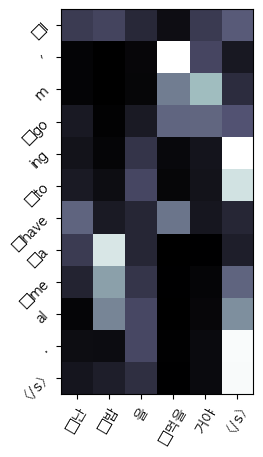

In [26]:
src = '난 밥을 먹을거야'
key = tokenizer.tokenize(src + ' </s>') 

translated_text, attention_weight_enc, attention_weight_dec, attention_weight_enc_dec = translation(model, tokenizer, src, max_len)
dec_tokens = tokenizer.tokenize(translated_text)
dec_input = dec_tokens[:-1] 
query = dec_tokens[1:] 

print('input: ', src)
print('output: ', translated_text, '\n')

print('input tokens shape: ', len(key))
print('output tokens shape: ', len(query), '\n')

plot_attention(attention_weight_enc_dec, query, key, n_head) 